In [1]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from s3dis_metrics import SegmentationMetrics
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import wandb
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
FILE = "./data/full_scan.ply"

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [4]:
s_val = PointCloudDataset(FILE)

In [5]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: divide by zero encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: overflow encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: invalid value encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T


In [6]:
# sem_seg.visualize_pcd()

In [7]:
sem_seg.ransac_segment()

Starting structural segmentation...
Detecting floor and ceiling...
  Floor found: 221860 points
  Ceiling found: 119914 points
Segmentation complete in 6.83 seconds
Found: 2 structural elements
  floor: 1
  ceiling: 1
Remaining unsegmented points: 797405


In [8]:
# sem_seg.ransac_segmentor.visualize_segments()

In [9]:
n = sem_seg.ransac_segmentor.segments["ceiling"]["plane"]["normal"]
target = np.array([0., 0., -1.])
angle = np.degrees(np.arccos(np.clip(np.abs(np.dot(n, target)), -1, 1)))
angle

np.float64(0.15257884758987522)

In [10]:
remainig_ind = sem_seg.ransac_segmentor.remaining_indices

In [11]:
points = sem_seg.points[remainig_ind]

In [12]:
def extract_wall_points(points, floor_height, ceiling_height, 
                       floor_margin=0.1, ceiling_margin=0.1):
    """
    Keep only points between floor and ceiling (potential walls)
    
    Args:
        points: Nx3 array
        floor_height: float
        ceiling_height: float
        floor_margin: Distance above floor to include (m)
        ceiling_margin: Distance below ceiling to include (m)
    
    Returns:
        wall_points: Filtered points
        wall_mask: Boolean mask
    """
    z_values = points[:, 2]
    
    wall_mask = (z_values > floor_height + floor_margin) & \
                (z_values < ceiling_height - ceiling_margin)
    
    wall_points = points[wall_mask]
    
    print(f"Original points: {len(points)}")
    print(f"Wall points: {len(wall_points)} ({100*len(wall_points)/len(points):.1f}%)")
    
    return wall_points, wall_mask

In [13]:
def visualize_wall_points(wall_points):
    """Visualize extracted wall points"""
    pcd_walls = o3d.geometry.PointCloud()
    pcd_walls.points = o3d.utility.Vector3dVector(wall_points)
    pcd_walls.paint_uniform_color([0, 1, 0])  # Green
    
    o3d.visualization.draw_geometries([pcd_walls], 
                                      window_name="Wall Points (Green)")

In [14]:
floor_h, ceiling_h = sem_seg.ransac_segmentor.get_floor_height(), sem_seg.ransac_segmentor.get_ceiling_height()

In [15]:
floor_h, ceiling_h

(np.float64(-1.446772952826721), np.float64(1.1844356077620508))

In [16]:
wall_points, wall_mask = extract_wall_points(points[:, :3], floor_h, ceiling_h)

Original points: 797405
Wall points: 770158 (96.6%)


In [17]:
# visualize_wall_points(wall_points)

In [18]:
def compute_normals(points, radius=0.1, max_nn=30):
    """
    Compute normal vectors for each point
    
    Args:
        points: Nx3 array
        radius: Search radius for normal estimation
        max_nn: Max number of neighbors
    
    Returns:
        normals: Nx3 array of normal vectors
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=radius, 
            max_nn=max_nn
        )
    )
    
    # Orient normals consistently (optional but helpful)
    pcd.orient_normals_consistent_tangent_plane(k=15)
    
    normals = np.asarray(pcd.normals)
    
    print(f"Computed normals for {len(normals)} points")
    
    return normals, pcd

In [19]:
def filter_vertical_points(points, normals, vertical_threshold=0.1):
    """
    Keep only points with vertical normals (walls)
    
    Args:
        points: Nx3 array
        normals: Nx3 array
        vertical_threshold: Max abs(normal_z) for vertical surfaces
    
    Returns:
        vertical_points: Filtered points
        vertical_normals: Corresponding normals
        vertical_mask: Boolean mask
    """
    # Vertical surfaces have normals with small Z component
    normal_z = np.abs(normals[:, 2])
    vertical_mask = normal_z < vertical_threshold
    
    vertical_points = points[vertical_mask]
    vertical_normals = normals[vertical_mask]
    
    print(f"Wall points: {len(points)}")
    print(f"Vertical wall points: {len(vertical_points)} "
          f"({100*len(vertical_points)/len(points):.1f}%)")
    
    return vertical_points, vertical_normals, vertical_mask

In [20]:
normals, pcd_with_normals = compute_normals(wall_points)

Computed normals for 770158 points


In [21]:
vertical_points, vertical_normals, vert_mask = filter_vertical_points(
    wall_points, normals
)

Wall points: 770158
Vertical wall points: 463510 (60.2%)


In [22]:
pcd_vert = o3d.geometry.PointCloud()
pcd_vert.points = o3d.utility.Vector3dVector(vertical_points)
pcd_vert.normals = o3d.utility.Vector3dVector(vertical_normals)
pcd_vert.paint_uniform_color([1, 0, 1])  # Magenta
o3d.visualization.draw_geometries([pcd_vert], window_name="Vertical Wall Points")

In [23]:
def create_2d_occupancy_grid(points, resolution=0.05):
    """
    Project wall points to 2D and create occupancy grid
    
    Args:
        points: Nx3 array (vertical wall points)
        resolution: Grid cell size in meters
    
    Returns:
        grid: 2D binary array (1=occupied, 0=free)
        origin: (min_x, min_y) for coordinate transform
        grid_size: (width, height) in cells
    """
    # Project to 2D (top-down view)
    points_2d = points[:, :2]  # Take only X, Y
    
    # Compute grid bounds
    min_x, min_y = points_2d.min(axis=0)
    max_x, max_y = points_2d.max(axis=0)
    
    # Add padding
    padding = 0.5  # meters
    min_x -= padding
    min_y -= padding
    max_x += padding
    max_y += padding
    
    # Calculate grid dimensions
    width = int(np.ceil((max_x - min_x) / resolution))
    height = int(np.ceil((max_y - min_y) / resolution))
    
    print(f"Grid size: {width} x {height} cells")
    print(f"Physical size: {max_x-min_x:.2f}m x {max_y-min_y:.2f}m")
    print(f"Resolution: {resolution}m/cell")
    
    # Create empty grid
    grid = np.zeros((height, width), dtype=np.uint8)
    
    # Fill grid with points
    for point in points_2d:
        # Convert to grid coordinates
        grid_x = int((point[0] - min_x) / resolution)
        grid_y = int((point[1] - min_y) / resolution)
        
        # Bounds check
        if 0 <= grid_x < width and 0 <= grid_y < height:
            grid[grid_y, grid_x] = 1
    
    origin = (min_x, min_y)
    grid_size = (width, height)
    
    occupied_cells = np.sum(grid)
    print(f"Occupied cells: {occupied_cells} ({100*occupied_cells/(width*height):.1f}%)")
    
    return grid, origin, resolution

In [24]:
def visualize_2d_grid(grid, title="Occupancy Grid"):
    """
    Visualize the 2D occupancy grid
    """
    plt.figure(figsize=(12, 10))
    plt.imshow(grid, cmap='binary', origin='lower')
    plt.title(title)
    plt.xlabel('X (grid cells)')
    plt.ylabel('Y (grid cells)')
    plt.colorbar(label='Occupied (1) / Free (0)')
    plt.tight_layout()
    plt.show()

Grid size: 201 x 293 cells
Physical size: 10.00m x 14.63m
Resolution: 0.05m/cell
Occupied cells: 6390 (10.9%)


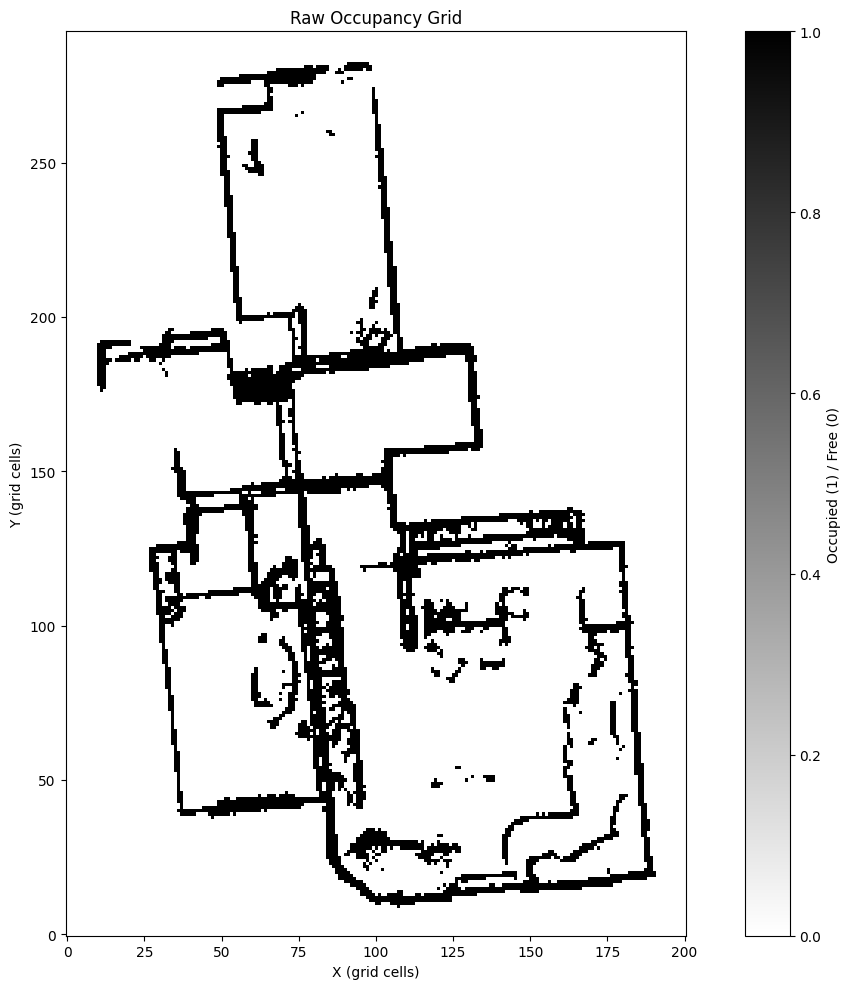

In [26]:
grid, origin, resolution = create_2d_occupancy_grid(vertical_points, resolution=0.05)
visualize_2d_grid(grid, "Raw Occupancy Grid")

In [24]:
from scipy import ndimage
from skimage import morphology

def close_small_gaps(grid, door_size_cells=20):
    """
    Close small gaps (doors) in walls using morphological closing
    
    Args:
        grid: 2D binary array
        door_size_cells: Max gap size to close (in cells)
                        For 0.05m resolution, 20 cells = 1.0m (typical door)
    
    Returns:
        closed_grid: Grid with gaps closed
    """
    # Create circular structuring element
    kernel_radius = door_size_cells // 2
    kernel = morphology.disk(kernel_radius)
    
    print(f"Closing gaps up to {door_size_cells * 0.05:.2f}m (door size)")
    
    # Morphological closing (dilation followed by erosion)
    closed_grid = morphology.binary_closing(grid, kernel)
    
    return closed_grid.astype(np.uint8)


def invert_grid(grid):
    """
    Invert grid: walls become 0, free space becomes 1
    This allows us to find connected free space (rooms)
    """
    return 1 - grid

In [27]:
def visualize_rooms(room_labels):
    """
    Visualize segmented rooms with different colors
    """
    plt.figure(figsize=(14, 12))
    
    # Use a colormap that shows distinct colors per room
    cmap = plt.cm.get_cmap('tab20', room_labels.max() + 1)
    
    plt.imshow(room_labels, cmap=cmap, origin='lower', interpolation='nearest')
    plt.title(f'Room Segmentation ({room_labels.max()} rooms)')
    plt.xlabel('X (grid cells)')
    plt.ylabel('Y (grid cells)')
    
    # Add colorbar with room numbers
    cbar = plt.colorbar(ticks=range(room_labels.max() + 1))
    cbar.set_label('Room ID')
    
    plt.tight_layout()
    plt.show()

In [28]:
def segment_rooms_final_fixed(grid, resolution=0.05,
                              door_size_cells=20,
                              wall_dilation=4,
                              min_distance=30,
                              min_room_size=500,
                              exclude_border=True):
    """
    Fixed version that returns origin
    """
    from skimage import morphology
    from scipy.ndimage import label as nd_label, distance_transform_edt
    from skimage.feature import peak_local_max
    from skimage.segmentation import watershed
    
    print("Step 1: Closing doors...")
    kernel = morphology.disk(door_size_cells // 2)
    closed_grid = morphology.binary_closing(grid, kernel).astype(np.uint8)
    
    print("Step 2: Dilating walls...")
    kernel_dilate = morphology.disk(wall_dilation)
    dilated_grid = morphology.binary_dilation(closed_grid, kernel_dilate).astype(np.uint8)
    
    # Invert
    inverted = 1 - dilated_grid
    
    print("Step 3: Finding interior regions...")
    labeled_regions, num_regions = nd_label(inverted)
    
    from scipy.ndimage import center_of_mass
    region_sizes = np.bincount(labeled_regions.ravel())
    region_sizes[0] = 0
    
    h, w = grid.shape
    border_margin = 10
    
    interior_region_ids = []
    
    for region_id in range(1, num_regions + 1):
        if region_sizes[region_id] < min_room_size:
            continue
            
        region_mask = labeled_regions == region_id
        
        if exclude_border:
            edge_cells = (
                np.sum(region_mask[:border_margin, :]) +
                np.sum(region_mask[-border_margin:, :]) +
                np.sum(region_mask[:, :border_margin]) +
                np.sum(region_mask[:, -border_margin:])
            )
            
            edge_ratio = edge_cells / region_sizes[region_id]
            
            if edge_ratio > 0.3:
                print(f"  Excluding region {region_id} (edge ratio: {edge_ratio:.2%})")
                continue
        
        interior_region_ids.append(region_id)
        area = region_sizes[region_id] * (resolution ** 2)
        print(f"  Interior region {region_id}: {region_sizes[region_id]} cells ({area:.1f} m²)")
    
    interior_mask = np.zeros_like(inverted, dtype=bool)
    for region_id in interior_region_ids:
        interior_mask |= (labeled_regions == region_id)
    
    print(f"\nStep 4: Watershed on {len(interior_region_ids)} interior regions...")
    
    distance = distance_transform_edt(interior_mask)
    coords = peak_local_max(distance, min_distance=min_distance, labels=interior_mask)
    
    print(f"  Found {len(coords)} room centers")
    
    if len(coords) == 0:
        print("⚠️  No room centers found!")
        return interior_mask.astype(np.uint8), 0
    
    markers = np.zeros_like(interior_mask, dtype=int)
    for i, (y, x) in enumerate(coords, start=1):
        markers[y, x] = i
    
    room_labels = watershed(-distance, markers, mask=interior_mask)
    
    final_labels = np.zeros_like(room_labels)
    room_id = 1
    
    for region_id in range(1, len(coords) + 1):
        region_mask = room_labels == region_id
        region_size = np.sum(region_mask)
        
        if region_size >= min_room_size:
            area_m2 = region_size * (resolution ** 2)
            print(f"  Room {room_id}: {region_size} cells ({area_m2:.1f} m²)")
            final_labels[region_mask] = room_id
            room_id += 1
    
    num_rooms = room_id - 1
    print(f"\n✓ Final: {num_rooms} rooms")
    
    return final_labels, num_rooms  # Only returns labels and count - NO ORIGIN!

In [29]:
room_labels, num_rooms = segment_rooms_final_fixed(
    grid,  # Use the SAME grid from step 5
    resolution=resolution,
    door_size_cells=20,
    wall_dilation=5,
    min_distance=35,
    min_room_size=500,
    exclude_border=True
)

Step 1: Closing doors...
Step 2: Dilating walls...
Step 3: Finding interior regions...
  Excluding region 1 (edge ratio: 33.72%)
  Interior region 2: 2377 cells (5.9 m²)
  Interior region 3: 1113 cells (2.8 m²)
  Interior region 5: 884 cells (2.2 m²)
  Interior region 6: 1742 cells (4.4 m²)

Step 4: Watershed on 4 interior regions...
  Found 4 room centers
  Room 1: 1742 cells (4.4 m²)
  Room 2: 2377 cells (5.9 m²)
  Room 3: 884 cells (2.2 m²)
  Room 4: 1113 cells (2.8 m²)

✓ Final: 4 rooms


/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_55228/2788333181.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', room_labels.max() + 1)


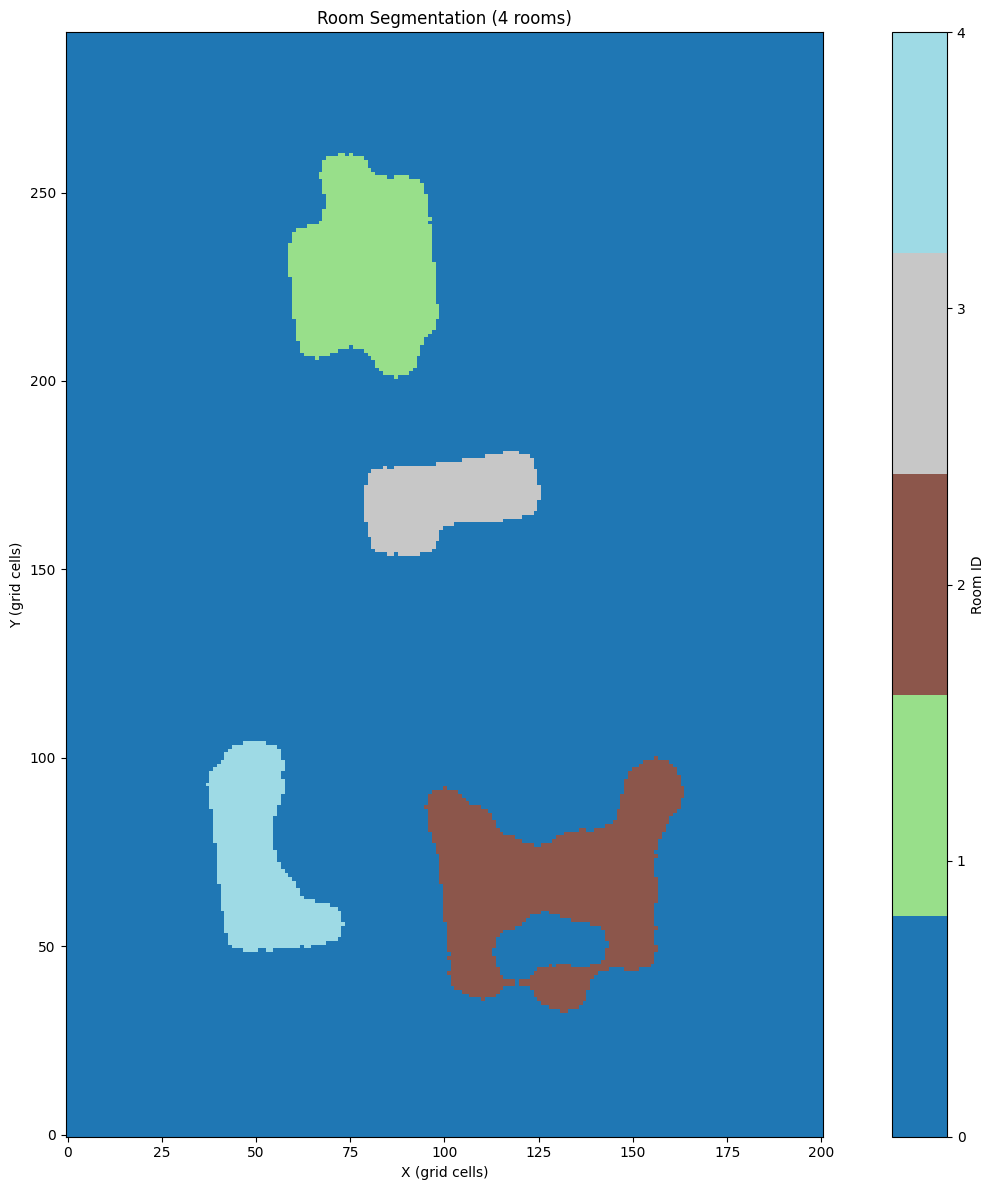

In [30]:
visualize_rooms(room_labels)

In [31]:
def assign_points_to_rooms_with_dilation(points, room_labels, origin, resolution, 
                                         dilation_cells=3):
    """
    Assign points to rooms, dilating room regions to capture wall points
    
    Args:
        points: Nx3 array
        room_labels: 2D grid with room IDs
        origin: (min_x, min_y)
        resolution: Grid resolution
        dilation_cells: How many cells to expand each room
    
    Returns:
        point_room_ids: Room ID for each point
    """
    from skimage import morphology
    
    print(f"Dilating room regions by {dilation_cells} cells ({dilation_cells * resolution:.2f}m)...")
    
    # Create dilated version of room labels
    dilated_labels = np.zeros_like(room_labels)
    
    # Dilate each room separately to avoid overlap conflicts
    num_rooms = room_labels.max()
    
    for room_id in range(1, num_rooms + 1):
        # Get mask for this room
        room_mask = (room_labels == room_id)
        
        # Dilate this room's region
        kernel = morphology.disk(dilation_cells)
        dilated_room = morphology.binary_dilation(room_mask, kernel)
        
        # Assign to dilated labels (later rooms overwrite earlier ones in overlaps)
        dilated_labels[dilated_room] = room_id
    
    # Now assign points using dilated labels
    min_x, min_y = origin
    height, width = room_labels.shape
    
    point_room_ids = np.zeros(len(points), dtype=np.int32)
    out_of_bounds = 0
    
    for i, point in enumerate(points):
        grid_x = int((point[0] - min_x) / resolution)
        grid_y = int((point[1] - min_y) / resolution)
        
        if 0 <= grid_x < width and 0 <= grid_y < height:
            point_room_ids[i] = dilated_labels[grid_y, grid_x]
        else:
            out_of_bounds += 1
    
    # Statistics
    print(f"\nResults:")
    print(f"  Out of bounds: {out_of_bounds} points")
    
    for room_id in range(1, num_rooms + 1):
        num_points = np.sum(point_room_ids == room_id)
        print(f"  Room {room_id}: {num_points} points")
    
    unassigned = np.sum(point_room_ids == 0)
    print(f"  Unassigned: {unassigned} points")
    
    # Visualize dilated room labels
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 10))
    plt.imshow(dilated_labels, cmap='tab20', origin='lower')
    plt.title('Dilated Room Labels')
    plt.colorbar()
    plt.show()
    
    return point_room_ids

Dilating room regions by 10 cells (0.50m)...

Results:
  Out of bounds: 0 points
  Room 1: 42757 points
  Room 2: 23172 points
  Room 3: 55121 points
  Room 4: 49674 points
  Unassigned: 292786 points


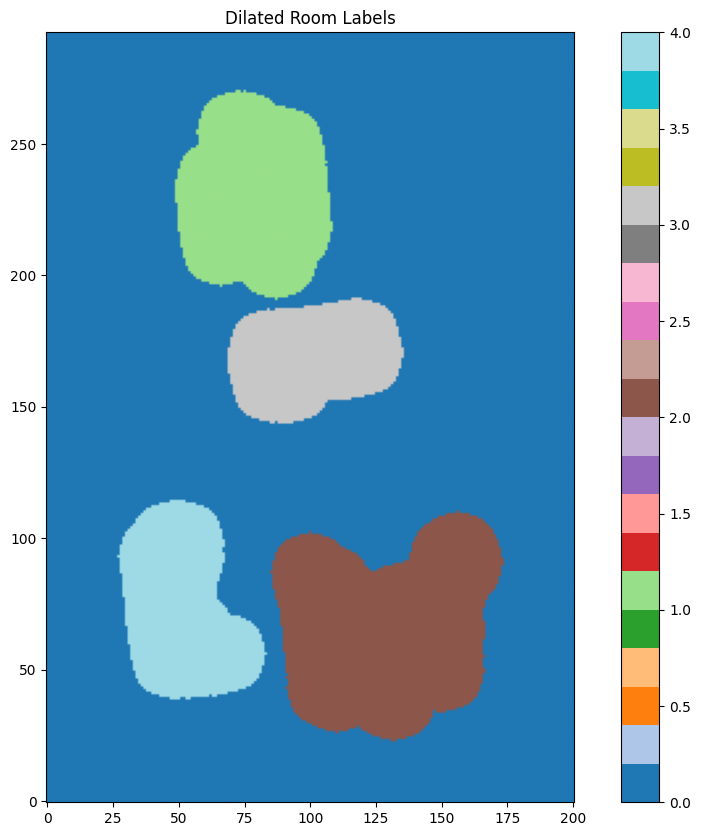

In [32]:
point_room_ids = assign_points_to_rooms_with_dilation(
    vertical_points,
    room_labels,
    origin,
    resolution,
    dilation_cells=10  # Expand rooms by 5 cells (0.25m) to capture walls
)

In [33]:
def assign_remaining_to_nearest_room(points, point_room_ids, room_labels, 
                                     origin, resolution):
    """
    Assign unassigned points (room 0) to nearest room
    """
    from scipy.ndimage import distance_transform_edt
    
    unassigned_mask = (point_room_ids == 0)
    num_unassigned = np.sum(unassigned_mask)
    
    print(f"\nAssigning {num_unassigned} unassigned points to nearest room...")
    
    if num_unassigned == 0:
        return point_room_ids
    
    min_x, min_y = origin
    height, width = room_labels.shape
    num_rooms = room_labels.max()
    
    # Compute distance to each room
    nearest_room_grid = np.zeros_like(room_labels)
    min_distance_grid = np.full_like(room_labels, fill_value=np.inf, dtype=float)
    
    for room_id in range(1, num_rooms + 1):
        room_mask = (room_labels == room_id)
        
        # Expand room mask with previous dilation
        from skimage import morphology
        kernel = morphology.disk(10)
        expanded_room = morphology.binary_dilation(room_mask, kernel)
        
        # Distance from each cell to this expanded room
        distance = distance_transform_edt(~expanded_room)
        
        # Track nearest room
        closer_mask = distance < min_distance_grid
        nearest_room_grid[closer_mask] = room_id
        min_distance_grid[closer_mask] = distance[closer_mask]
    
    # Assign unassigned points
    updated_ids = point_room_ids.copy()
    
    for i in np.where(unassigned_mask)[0]:
        point = points[i]
        grid_x = int((point[0] - min_x) / resolution)
        grid_y = int((point[1] - min_y) / resolution)
        
        if 0 <= grid_x < width and 0 <= grid_y < height:
            updated_ids[i] = nearest_room_grid[grid_y, grid_x]
    
    # Statistics
    print("\nFinal assignment:")
    for room_id in range(1, num_rooms + 1):
        num_points = np.sum(updated_ids == room_id)
        print(f"  Room {room_id}: {num_points} points")
    
    remaining_unassigned = np.sum(updated_ids == 0)
    print(f"  Still unassigned: {remaining_unassigned} points")
    
    return updated_ids

Dilating room regions by 10 cells (0.50m)...

Results:
  Out of bounds: 0 points
  Room 1: 42757 points
  Room 2: 23172 points
  Room 3: 55121 points
  Room 4: 49674 points
  Unassigned: 292786 points


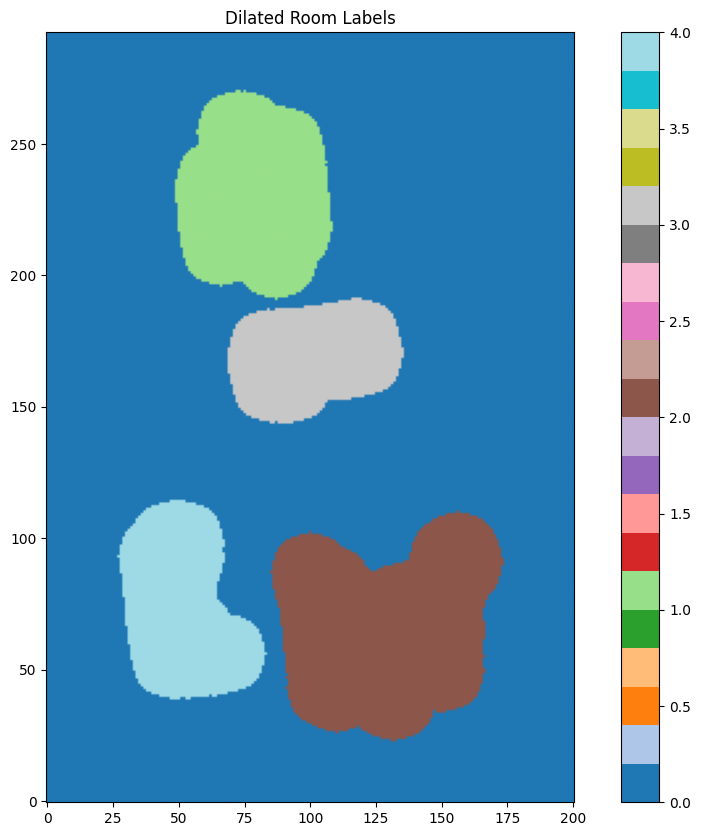

In [34]:
point_room_ids = assign_points_to_rooms_with_dilation(
    vertical_points, room_labels, origin, resolution, dilation_cells=10
)

In [37]:
point_room_ids_final = assign_remaining_to_nearest_room(
    vertical_points, point_room_ids, room_labels, origin, resolution
)


Assigning 292786 unassigned points to nearest room...

Final assignment:
  Room 1: 79439 points
  Room 2: 151364 points
  Room 3: 119321 points
  Room 4: 113386 points
  Still unassigned: 0 points


In [38]:
def visualize_rooms_3d(points, room_ids, num_rooms):
    """
    Visualize 3D points colored by room
    
    Args:
        points: Nx3 array of points
        room_ids: Room ID for each point
        num_rooms: Total number of rooms
    """
    import matplotlib.pyplot as plt
    
    # Create colormap
    colors = plt.cm.tab20(np.linspace(0, 1, num_rooms + 1))
    
    point_colors = np.zeros((len(points), 3))
    for room_id in range(num_rooms + 1):
        mask = room_ids == room_id
        point_colors[mask] = colors[room_id, :3]
    
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(point_colors)
    
    o3d.visualization.draw_geometries([pcd], 
                                      window_name="Rooms in 3D (Color=Room)")

In [39]:
visualize_rooms_3d(vertical_points, point_room_ids_final, num_rooms)

In [40]:
def print_room_summary(point_room_ids, num_rooms):
    """
    Print summary of point assignments
    """
    print("\n=== Room Assignment Summary ===")
    for room_id in range(num_rooms + 1):
        count = np.sum(point_room_ids == room_id)
        percentage = 100 * count / len(point_room_ids)
        
        if room_id == 0:
            print(f"  Unassigned (Room 0): {count} points ({percentage:.1f}%)")
        else:
            print(f"  Room {room_id}: {count} points ({percentage:.1f}%)")
    
    print(f"\nTotal points: {len(point_room_ids)}")

In [41]:
print_room_summary(point_room_ids_final, num_rooms)


=== Room Assignment Summary ===
  Unassigned (Room 0): 0 points (0.0%)
  Room 1: 79439 points (17.1%)
  Room 2: 151364 points (32.7%)
  Room 3: 119321 points (25.7%)
  Room 4: 113386 points (24.5%)

Total points: 463510


In [42]:
def detect_walls_per_room(vertical_points, point_room_ids, num_rooms,
                          distance_threshold=0.03,
                          min_wall_length=0.5,
                          min_inliers=50):
    """
    Detect wall planes in each room using RANSAC
    
    Args:
        vertical_points: Nx3 array of wall points
        point_room_ids: Room ID for each point
        num_rooms: Total number of rooms
        distance_threshold: RANSAC inlier distance
        min_wall_length: Minimum wall length (m)
        min_inliers: Minimum points for valid wall
    
    Returns:
        walls: Dictionary mapping room_id -> list of wall planes
    """
    walls = {}
    
    for room_id in range(1, num_rooms + 1):
        print(f"\n=== Room {room_id} ===")
        
        # Extract points for this room
        room_mask = point_room_ids == room_id
        room_points = vertical_points[room_mask]
        
        if len(room_points) < 100:
            print(f"  Too few points ({len(room_points)}), skipping")
            continue
        
        print(f"  Points: {len(room_points)}")
        
        # Detect multiple walls in this room
        room_walls = []
        remaining_points = room_points.copy()
        
        max_walls = 20  # Safety limit
        
        for wall_idx in range(max_walls):
            if len(remaining_points) < min_inliers:
                break
            
            # Create point cloud
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(remaining_points)
            
            # RANSAC for plane
            plane_model, inliers = pcd.segment_plane(
                distance_threshold=distance_threshold,
                ransac_n=3,
                num_iterations=1000
            )
            
            if len(inliers) < min_inliers:
                break
            
            [a, b, c, d] = plane_model
            
            # Check if it's actually vertical (z-component of normal should be small)
            if abs(c) > 0.3:  # Not vertical enough
                # Remove these points and continue
                remaining_points = np.delete(remaining_points, inliers, axis=0)
                continue
            
            # Get inlier points
            inlier_points = remaining_points[inliers]
            
            # Check wall length
            points_2d = inlier_points[:, :2]
            if len(points_2d) > 2:
                from scipy.spatial import ConvexHull
                try:
                    hull = ConvexHull(points_2d)
                    perimeter = hull.area  # In 2D, area is perimeter
                    
                    # Estimate wall length (perimeter / 2 for roughly rectangular wall)
                    wall_length = perimeter / 2
                    
                    if wall_length < min_wall_length:
                        remaining_points = np.delete(remaining_points, inliers, axis=0)
                        continue
                except:
                    wall_length = 0
            
            # Valid wall found
            wall_info = {
                'plane_model': plane_model,
                'inliers': inlier_points,
                'num_inliers': len(inliers),
                'length': wall_length if 'wall_length' in locals() else 0
            }
            
            room_walls.append(wall_info)
            print(f"  Wall {len(room_walls)}: {len(inliers)} points, "
                  f"normal=[{a:.2f}, {b:.2f}, {c:.2f}], "
                  f"length≈{wall_length:.2f}m")
            
            # Remove inliers for next iteration
            remaining_points = np.delete(remaining_points, inliers, axis=0)
        
        walls[room_id] = room_walls
        print(f"  Total walls detected: {len(room_walls)}")
    
    return walls


def visualize_walls_per_room(vertical_points, point_room_ids, walls, num_rooms):
    """
    Visualize detected walls with different colors per room
    """
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    
    # Assign colors
    point_colors = np.zeros((len(vertical_points), 3))
    
    for room_id in tqdm(range(1, num_rooms + 1)):
        if room_id not in walls:
            continue
        
        room_walls = walls[room_id]
        room_color = plt.cm.tab10(room_id % 10)[:3]
        
        # Color each wall in this room
        for wall_idx, wall_info in enumerate(room_walls):
            wall_inliers = wall_info['inliers']
            print("added")
            
            # Find these points in the full point cloud
            for i, point in tqdm(enumerate(vertical_points)):
                if point_room_ids[i] == room_id:
                    # Check if point is in this wall
                    distances = np.linalg.norm(wall_inliers - point, axis=1)
                    if np.min(distances) < 0.01:  # Same point
                        # Vary brightness per wall
                        brightness = 0.5 + (wall_idx * 0.5 / len(room_walls))
                        point_colors[i] = np.array(room_color) * brightness
    
    # Visualize
    print("viz")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(vertical_points)
    pcd.colors = o3d.utility.Vector3dVector(point_colors)
    
    o3d.visualization.draw_geometries([pcd], 
                                      window_name="Walls per Room")

In [44]:
def detect_walls_per_room_strict(vertical_points, point_room_ids, num_rooms,
                                 distance_threshold=0.03,
                                 min_wall_length=1.2,  # Increased from 0.5m
                                 min_inliers=200,      # Increased from 50
                                 min_wall_area=2.0):   # New: minimum wall area
    """
    Stricter wall detection to filter furniture
    """
    walls = {}
    
    for room_id in range(1, num_rooms + 1):
        print(f"\n=== Room {room_id} ===")
        
        room_mask = point_room_ids == room_id
        room_points = vertical_points[room_mask]
        
        if len(room_points) < 100:
            print(f"  Too few points ({len(room_points)}), skipping")
            continue
        
        print(f"  Points: {len(room_points)}")
        
        room_walls = []
        remaining_points = room_points.copy()
        
        max_walls = 20
        
        for wall_idx in range(max_walls):
            if len(remaining_points) < min_inliers:
                break
            
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(remaining_points)
            
            plane_model, inliers = pcd.segment_plane(
                distance_threshold=distance_threshold,
                ransac_n=3,
                num_iterations=1000
            )
            
            if len(inliers) < min_inliers:
                break
            
            [a, b, c, d] = plane_model
            
            # Check verticality
            if abs(c) > 0.3:
                remaining_points = np.delete(remaining_points, inliers, axis=0)
                continue
            
            inlier_points = remaining_points[inliers]
            
            # Calculate wall properties
            points_2d = inlier_points[:, :2]
            z_values = inlier_points[:, 2]
            
            wall_height = z_values.max() - z_values.min()
            
            # Calculate length and area
            if len(points_2d) > 2:
                from scipy.spatial import ConvexHull
                try:
                    hull = ConvexHull(points_2d)
                    perimeter = hull.area
                    wall_length = perimeter / 2
                    
                    # Estimate area (length × height)
                    wall_area = wall_length * wall_height
                    
                    # STRICT FILTERING
                    if (wall_length < min_wall_length or 
                        wall_area < min_wall_area or
                        wall_height < 1.0):  # At least 1m tall
                        
                        print(f"  Rejected: len={wall_length:.2f}m, "
                              f"h={wall_height:.2f}m, area={wall_area:.2f}m²")
                        remaining_points = np.delete(remaining_points, inliers, axis=0)
                        continue
                    
                except:
                    wall_length = 0
                    wall_area = 0
                    remaining_points = np.delete(remaining_points, inliers, axis=0)
                    continue
            else:
                remaining_points = np.delete(remaining_points, inliers, axis=0)
                continue
            
            # Valid wall
            wall_info = {
                'plane_model': plane_model,
                'inliers': inlier_points,
                'num_inliers': len(inliers),
                'length': wall_length,
                'height': wall_height,
                'area': wall_area
            }
            
            room_walls.append(wall_info)
            print(f"  Wall {len(room_walls)}: {len(inliers)} points, "
                  f"len={wall_length:.2f}m, h={wall_height:.2f}m, area={wall_area:.2f}m²")
            
            remaining_points = np.delete(remaining_points, inliers, axis=0)
        
        walls[room_id] = room_walls
        print(f"  Total walls: {len(room_walls)}")
    
    return walls

In [121]:
walls = detect_walls_per_room(
    vertical_points,
    point_room_ids_final,
    num_rooms,
    distance_threshold=0.05,
    min_wall_length=0.5,
    min_inliers=50
)


=== Room 1 ===
  Points: 79439
  Wall 1: 25504 points, normal=[0.99, 0.10, -0.00], length≈4.28m
  Wall 2: 21719 points, normal=[1.00, 0.09, 0.01], length≈3.91m
  Wall 3: 9936 points, normal=[-0.21, 0.98, 0.01], length≈4.93m
  Wall 4: 4763 points, normal=[-0.09, 1.00, -0.01], length≈4.80m
  Wall 5: 4101 points, normal=[-0.15, 0.99, 0.00], length≈2.39m
  Wall 6: 2873 points, normal=[0.97, 0.26, -0.01], length≈4.60m
  Wall 7: 2688 points, normal=[-0.19, 0.98, 0.01], length≈4.59m
  Wall 8: 2041 points, normal=[-0.23, 0.97, 0.01], length≈4.59m
  Wall 9: 1950 points, normal=[-0.09, 1.00, 0.00], length≈0.86m
  Wall 10: 1487 points, normal=[1.00, 0.06, -0.00], length≈0.71m
  Wall 11: 598 points, normal=[0.96, 0.24, 0.11], length≈4.64m
  Wall 12: 515 points, normal=[-0.12, 0.99, -0.04], length≈1.80m
  Wall 13: 319 points, normal=[0.98, -0.17, 0.06], length≈4.61m
  Wall 14: 214 points, normal=[-0.23, 0.97, 0.03], length≈4.93m
  Wall 15: 152 points, normal=[-0.22, 0.98, -0.01], length≈3.57m
  Wa

In [ ]:
walls_strict = detect_walls_per_room_strict(
    vertical_points,
    point_room_ids_final,
    num_rooms,
    distance_threshold=0.1,
    min_wall_length=1.2,     # Furniture is usually < 1.2m
    min_inliers=200,         # Furniture has fewer points
    min_wall_area=2.0        # 2m² minimum (e.g., 2m × 1m)
)


=== Room 1 ===
  Points: 79439
  Wall 1: 16449 points, len=4.21m, h=2.43m, area=10.23m²
  Wall 2: 13156 points, len=3.41m, h=2.43m, area=8.28m²
  Wall 3: 3246 points, len=3.92m, h=2.43m, area=9.51m²
  Wall 4: 4782 points, len=3.42m, h=2.43m, area=8.31m²
  Wall 5: 3173 points, len=3.31m, h=2.43m, area=8.03m²
  Wall 6: 3770 points, len=4.88m, h=2.41m, area=11.75m²
  Wall 7: 2816 points, len=3.72m, h=2.43m, area=9.04m²
  Wall 8: 2529 points, len=4.54m, h=2.34m, area=10.64m²
  Wall 9: 1993 points, len=4.74m, h=2.41m, area=11.42m²
  Wall 10: 1836 points, len=3.34m, h=2.42m, area=8.10m²
  Wall 11: 2121 points, len=4.90m, h=2.35m, area=11.53m²
  Wall 12: 849 points, len=1.52m, h=2.37m, area=3.60m²
  Rejected: len=0.88m, h=1.07m, area=0.95m²
  Wall 13: 1204 points, len=2.24m, h=1.54m, area=3.45m²
  Wall 14: 1358 points, len=3.71m, h=2.33m, area=8.66m²
  Wall 15: 787 points, len=4.96m, h=2.41m, area=11.94m²
  Wall 16: 840 points, len=3.30m, h=2.42m, area=7.97m²
  Wall 17: 1050 points, len=3.65

In [46]:
def visualize_walls_per_room_fast(vertical_points, point_room_ids, walls, num_rooms):
    """
    Fast visualization - assigns colors directly without nested loops
    """
    import matplotlib.pyplot as plt
    
    print("Creating visualization...")
    
    # Initialize all points as gray
    point_colors = np.ones((len(vertical_points), 3)) * 0.5
    
    for room_id in range(1, num_rooms + 1):
        if room_id not in walls:
            continue
        
        room_color = plt.cm.tab10(room_id % 10)[:3]
        room_walls = walls[room_id]
        
        # Color walls in this room
        for wall_idx, wall_info in enumerate(room_walls):
            wall_points = wall_info['inliers']
            
            # Vary brightness per wall
            brightness = 0.5 + (wall_idx * 0.5 / len(room_walls))
            wall_color = np.array(room_color) * brightness
            
            # Find these points by checking if they belong to this room
            room_mask = (point_room_ids == room_id)
            room_point_indices = np.where(room_mask)[0]
            
            # Use spatial hashing for faster lookup
            from scipy.spatial import cKDTree
            
            # Build KDTree for wall points
            tree = cKDTree(wall_points)
            
            # Query for room points within wall
            room_points_subset = vertical_points[room_mask]
            distances, indices = tree.query(room_points_subset, distance_upper_bound=0.02)
            
            # Points with distance < threshold belong to this wall
            wall_point_mask = distances < 0.02
            actual_indices = room_point_indices[wall_point_mask]
            
            point_colors[actual_indices] = wall_color
    
    # Visualize
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(vertical_points)
    pcd.colors = o3d.utility.Vector3dVector(point_colors)
    
    o3d.visualization.draw_geometries([pcd], window_name="Walls per Room (Fast)")


In [261]:
room_mask = point_room_ids_final == 2
room_points = vertical_points[room_mask]

In [262]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(room_points)


In [263]:
o3d.visualization.draw_geometries([pcd])

In [269]:
segment_models = {}
segments_ransac = {}

epsilon = 0.3
min_cluster_points = 10
max_plane_idx = 30
distance_threshold = 0.1
rest = pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=1000)
    if len(inliers) > 500:
        print(i, len(inliers))
        segments_ransac[i] = rest.select_by_index(inliers)
        labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
        candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
        best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
        # print(i, best_candidate)
        rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
        segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
        colors = plt.get_cmap("tab20")(i)
        segments_ransac[i].paint_uniform_color(list(colors[:3]))

0 31503
1 28018


/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_55228/1724338060.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


2 16653
3 15725
4 14585
5 13975
6 8327
7 7561
8 4830
9 4552
10 4333
11 3806
12 3796
13 3564
14 3327
15 3104
16 2644
17 2575
18 2501
19 2224
20 2038
21 2048
22 1890
23 1819
24 1631
25 1584
26 1473
27 1435
28 1423
29 1277


In [270]:
len(np.array(pcd.points))

151364

In [271]:
segments_ransac

{0: PointCloud with 31503 points.,
 1: PointCloud with 28018 points.,
 2: PointCloud with 9435 points.,
 3: PointCloud with 15449 points.,
 4: PointCloud with 13917 points.,
 5: PointCloud with 13941 points.,
 6: PointCloud with 5526 points.,
 7: PointCloud with 4825 points.,
 8: PointCloud with 1810 points.,
 9: PointCloud with 2814 points.,
 10: PointCloud with 2467 points.,
 11: PointCloud with 1130 points.,
 12: PointCloud with 1784 points.,
 13: PointCloud with 3541 points.,
 14: PointCloud with 1121 points.,
 15: PointCloud with 1035 points.,
 16: PointCloud with 645 points.,
 17: PointCloud with 515 points.,
 18: PointCloud with 967 points.,
 19: PointCloud with 674 points.,
 20: PointCloud with 659 points.,
 21: PointCloud with 401 points.,
 22: PointCloud with 375 points.,
 23: PointCloud with 326 points.,
 24: PointCloud with 1013 points.,
 25: PointCloud with 268 points.,
 26: PointCloud with 219 points.,
 27: PointCloud with 415 points.,
 28: PointCloud with 296 points.,
 2

In [273]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(len(segments_ransac)) if len(np.array(segments_ransac[i].points)) > 5000 ])

In [248]:
def detect_walls_per_room_clustered(vertical_points, point_room_ids, num_rooms,
                                    floor_height, ceiling_height,
                                    distance_threshold=0.03,
                                    cluster_eps=0.15,
                                    min_cluster_points=100,
                                    min_wall_height=1.5,
                                    min_wall_length=1.0,
                                    max_iterations=30):
    """
    Detect walls using RANSAC + DBSCAN clustering
    
    Process:
    1. RANSAC: Find plane
    2. DBSCAN: Cluster points on that plane (separates disconnected furniture)
    3. Keep largest cluster (main wall segment)
    4. Filter by size
    5. Repeat
    
    Args:
        vertical_points: Nx3 wall points
        point_room_ids: Room ID for each point
        num_rooms: Total rooms
        floor_height, ceiling_height: Room bounds
        distance_threshold: RANSAC plane distance (m)
        cluster_eps: DBSCAN epsilon (m) - distance between points in cluster
        min_cluster_points: Minimum points for valid cluster
        min_wall_height: Minimum wall height (m)
        min_wall_length: Minimum wall length (m)
        max_iterations: Maximum number of planes to detect per room
    
    Returns:
        walls: Dict of room_id -> list of wall info
    """
    walls = {}
    room_height = ceiling_height - floor_height
    
    for room_id in range(1, num_rooms + 1):
        print(f"\n{'='*60}")
        print(f"ROOM {room_id}")
        print('='*60)
        
        # Get room points
        room_mask = point_room_ids == room_id
        room_points = vertical_points[room_mask]
        
        if len(room_points) < min_cluster_points:
            print(f"Too few points: {len(room_points)}")
            continue
        
        print(f"Total points: {len(room_points)}")
        
        # Storage
        room_walls = []
        remaining_points = room_points.copy()
        
        # Iteratively find planes
        for iteration in range(max_iterations):
            if len(remaining_points) < min_cluster_points:
                print(f"\nStopping: Only {len(remaining_points)} points remaining")
                break
            
            print(f"\n--- Iteration {iteration + 1} ---")
            print(f"Remaining points: {len(remaining_points)}")
            
            # Create point cloud
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(remaining_points)
            
            # STEP 1: RANSAC - Find plane
            plane_model, inliers_idx = pcd.segment_plane(
                distance_threshold=distance_threshold,
                ransac_n=3,
                num_iterations=1000
            )
            
            if len(inliers_idx) < min_cluster_points:
                print(f"Plane too small: {len(inliers_idx)} points")
                break
            
            [a, b, c, d] = plane_model
            print(f"Plane found: {len(inliers_idx)} inliers, normal=[{a:.2f}, {b:.2f}, {c:.2f}]")
            
            # Check verticality
            if abs(c) > 0.3:
                print(f"Not vertical (|normal_z|={abs(c):.2f}), skipping")
                remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
                continue
            
            # Get inlier points
            inlier_points = remaining_points[inliers_idx]
            
            # STEP 2: DBSCAN - Cluster points on this plane
            pcd_inliers = o3d.geometry.PointCloud()
            pcd_inliers.points = o3d.utility.Vector3dVector(inlier_points)
            
            labels = np.array(pcd_inliers.cluster_dbscan(
                eps=cluster_eps,
                min_points=min_cluster_points
            ))
            
            # Find clusters
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[unique_labels >= 0]  # Remove noise (-1)
            
            if len(unique_labels) == 0:
                print("No valid clusters found")
                remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
                continue
            
            # Count points in each cluster
            cluster_sizes = []
            for label in unique_labels:
                cluster_size = np.sum(labels == label)
                cluster_sizes.append(cluster_size)
            
            print(f"Clusters found: {len(unique_labels)}")
            for label, size in zip(unique_labels, cluster_sizes):
                print(f"  Cluster {label}: {size} points")
            
            # STEP 3: Keep largest cluster (main wall segment)
            largest_cluster_idx = unique_labels[np.argmax(cluster_sizes)]
            largest_cluster_size = max(cluster_sizes)
            
            print(f"Largest cluster: {largest_cluster_idx} with {largest_cluster_size} points")
            
            # Extract largest cluster points
            largest_cluster_mask = (labels == largest_cluster_idx)
            wall_segment_points = inlier_points[largest_cluster_mask]
            
            # STEP 4: Validate wall segment
            # Check height
            z_values = wall_segment_points[:, 2]
            wall_height = z_values.max() - z_values.min()
            
            # Check length
            points_2d = wall_segment_points[:, :2]
            
            if len(points_2d) > 2:
                from scipy.spatial import ConvexHull
                try:
                    hull = ConvexHull(points_2d)
                    perimeter = hull.area
                    wall_length = perimeter / 2
                    wall_area = wall_length * wall_height
                except:
                    wall_length = 0
                    wall_area = 0
            else:
                wall_length = 0
                wall_area = 0
            
            # Height ratio
            height_ratio = wall_height / room_height
            
            # Filtering
            is_valid = (
                wall_height >= min_wall_height and
                wall_length >= min_wall_length and
                largest_cluster_size >= min_cluster_points
            )
            
            if not is_valid:
                print(f"❌ Rejected: h={wall_height:.2f}m, len={wall_length:.2f}m, "
                      f"pts={largest_cluster_size}")
                
                # Remove all inliers (including small clusters) from remaining
                remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
                continue
            
            # STEP 5: Store valid wall
            wall_info = {
                'plane_model': plane_model,
                'inliers': wall_segment_points,
                'num_inliers': largest_cluster_size,
                'length': wall_length,
                'height': wall_height,
                'area': wall_area,
                'height_ratio': height_ratio
            }
            
            room_walls.append(wall_info)
            
            print(f"✅ Wall {len(room_walls)}: {largest_cluster_size} points, "
                  f"len={wall_length:.2f}m, h={wall_height:.2f}m ({height_ratio*100:.0f}%), "
                  f"area={wall_area:.2f}m²")
            
            # Remove ALL inliers (including rejected small clusters)
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
        
        walls[room_id] = room_walls
        print(f"\n{'='*60}")
        print(f"Room {room_id} complete: {len(room_walls)} walls detected")
        print('='*60)
    
    return walls

In [276]:
walls_clustered = detect_walls_per_room_clustered(
    vertical_points,
    point_room_ids_final,
    num_rooms,
    floor_h,
    ceiling_h,
    distance_threshold=0.1,  # Plane fitting tolerance
    cluster_eps=0.3,         # DBSCAN: max distance between points (15cm)
    min_cluster_points=10,   # Minimum points for valid wall segment
    min_wall_height=1.5,      # Minimum 1.5m tall
    min_wall_length=0.5,      # Minimum 1.0m long
    max_iterations=30         # Max walls to detect per room
)


ROOM 1
Total points: 79439

--- Iteration 1 ---
Remaining points: 79439
Plane found: 25652 inliers, normal=[0.99, 0.10, -0.00]
Clusters found: 3
  Cluster 0: 25518 points
  Cluster 1: 44 points
  Cluster 2: 90 points
Largest cluster: 0 with 25518 points
✅ Wall 1: 25518 points, len=3.95m, h=2.43m (92%), area=9.59m²

--- Iteration 2 ---
Remaining points: 53787
Plane found: 22123 inliers, normal=[1.00, 0.09, 0.01]
Clusters found: 2
  Cluster 0: 22059 points
  Cluster 1: 63 points
Largest cluster: 0 with 22059 points
✅ Wall 2: 22059 points, len=3.57m, h=2.43m (92%), area=8.67m²

--- Iteration 3 ---
Remaining points: 31664
Plane found: 13360 inliers, normal=[-0.18, 0.98, -0.01]
Clusters found: 3
  Cluster 0: 8559 points
  Cluster 1: 4783 points
  Cluster 2: 18 points
Largest cluster: 0 with 8559 points
✅ Wall 3: 8559 points, len=2.20m, h=2.03m (77%), area=4.46m²

--- Iteration 4 ---
Remaining points: 18304
Plane found: 6621 inliers, normal=[-0.11, 0.99, 0.00]
Clusters found: 3
  Cluster 0:

In [277]:
visualize_walls_per_room_fast(vertical_points, point_room_ids_final, walls_clustered, num_rooms)

Creating visualization...


In [278]:
def merge_colinear_walls(walls, angle_threshold=10, distance_threshold=0.2):
    """
    Merge walls that are colinear (same plane, adjacent)
    
    Args:
        walls: List of wall info dicts
        angle_threshold: Max angle difference (degrees)
        distance_threshold: Max distance between walls (m)
    
    Returns:
        merged_walls: List of merged wall info
    """
    if len(walls) == 0:
        return []
    
    import math
    
    # Sort walls by number of points (largest first)
    sorted_walls = sorted(walls, key=lambda w: w['num_inliers'], reverse=True)
    
    merged = []
    used = set()
    
    for i, wall1 in enumerate(sorted_walls):
        if i in used:
            continue
        
        [a1, b1, c1, d1] = wall1['plane_model']
        normal1 = np.array([a1, b1, c1])
        normal1 = normal1 / np.linalg.norm(normal1)
        
        # Find similar walls to merge
        group = [wall1]
        group_indices = [i]
        
        for j, wall2 in enumerate(sorted_walls):
            if j <= i or j in used:
                continue
            
            [a2, b2, c2, d2] = wall2['plane_model']
            normal2 = np.array([a2, b2, c2])
            normal2 = normal2 / np.linalg.norm(normal2)
            
            # Check angle between normals
            dot_product = np.abs(np.dot(normal1, normal2))
            angle = math.degrees(math.acos(np.clip(dot_product, -1, 1)))
            
            if angle < angle_threshold:
                # Check distance between planes
                # Sample point from wall2
                if len(wall2['inliers']) > 0:
                    sample_point = wall2['inliers'][0]
                    
                    # Distance from point to plane1
                    dist = abs(a1*sample_point[0] + b1*sample_point[1] + c1*sample_point[2] + d1)
                    
                    if dist < distance_threshold:
                        group.append(wall2)
                        group_indices.append(j)
        
        # Mark as used
        used.update(group_indices)
        
        # Merge the group
        all_inliers = np.vstack([w['inliers'] for w in group])
        
        merged_wall = {
            'plane_model': wall1['plane_model'],  # Use largest wall's model
            'inliers': all_inliers,
            'num_inliers': len(all_inliers),
            'length': wall1['length'],  # Could recalculate
            'merged_from': len(group)
        }
        
        merged.append(merged_wall)
    
    return merged

In [279]:
def merge_walls_all_rooms(walls):
    """Merge colinear walls for all rooms"""
    merged_walls = {}
    
    for room_id, room_walls in walls.items():
        print(f"\nRoom {room_id}: {len(room_walls)} walls → ", end="")
        
        merged = merge_colinear_walls(room_walls, angle_threshold=10, distance_threshold=0.2)
        
        print(f"{len(merged)} merged walls")
        
        for i, wall in enumerate(merged):
            if wall['merged_from'] > 1:
                print(f"  Wall {i+1}: {wall['num_inliers']} points "
                      f"(merged from {wall['merged_from']} segments)")
        
        merged_walls[room_id] = merged
    
    return merged_walls

In [280]:
merged_walls = merge_walls_all_rooms(walls_clustered)


Room 1: 6 walls → 6 merged walls

Room 2: 10 walls → 10 merged walls

Room 3: 10 walls → 8 merged walls
  Wall 1: 27589 points (merged from 2 segments)
  Wall 3: 15446 points (merged from 2 segments)

Room 4: 7 walls → 7 merged walls


In [281]:
visualize_walls_per_room_fast(vertical_points, point_room_ids_final, merged_walls, num_rooms)

Creating visualization...


In [284]:
def extract_wall_2d_lines(walls_dict):
    """
    Convert 3D wall planes to 2D lines for floorplan
    
    For each wall:
    1. Project to 2D (top-down view)
    2. Find endpoints (convex hull or min/max along wall direction)
    3. Create line segment
    """
    wall_lines = {}
    
    for room_id, room_walls in walls_dict.items():
        print(f"\n=== Room {room_id} ===")
        lines = []
        
        for i, wall_info in enumerate(room_walls):
            # Get wall points and project to 2D
            wall_points_3d = wall_info['inliers']
            wall_points_2d = wall_points_3d[:, :2]  # Just X, Y
            
            if len(wall_points_2d) < 2:
                continue
            
            # Get wall normal (for orientation)
            [a, b, c, d] = wall_info['plane_model']
            normal_2d = np.array([a, b])
            normal_2d = normal_2d / np.linalg.norm(normal_2d)
            
            # Find wall endpoints using convex hull
            from scipy.spatial import ConvexHull
            try:
                hull = ConvexHull(wall_points_2d)
                hull_points = wall_points_2d[hull.vertices]
                
                # Find two furthest points on hull (wall endpoints)
                max_dist = 0
                endpoint1, endpoint2 = None, None
                
                for j in range(len(hull_points)):
                    for k in range(j+1, len(hull_points)):
                        dist = np.linalg.norm(hull_points[j] - hull_points[k])
                        if dist > max_dist:
                            max_dist = dist
                            endpoint1 = hull_points[j]
                            endpoint2 = hull_points[k]
                
                if endpoint1 is not None and max_dist > 0.5:  # At least 50cm
                    lines.append({
                        'start': endpoint1,
                        'end': endpoint2,
                        'length': max_dist,
                        'normal': normal_2d,
                        'num_points': len(wall_points_2d)
                    })
                    
                    print(f"  Wall {i+1}: [{endpoint1[0]:.2f}, {endpoint1[1]:.2f}] → "
                          f"[{endpoint2[0]:.2f}, {endpoint2[1]:.2f}] (length {max_dist:.2f}m)")
            
            except Exception as e:
                print(f"  Wall {i+1}: Could not extract line ({e})")
        
        wall_lines[room_id] = lines
    
    return wall_lines


In [285]:
wall_lines_2d = extract_wall_2d_lines(merged_walls)


=== Room 1 ===
  Wall 1: [2.81, 9.69] → [3.19, 5.79] (length 3.92m)
  Wall 2: [0.48, 9.34] → [0.65, 5.89] (length 3.45m)
  Wall 3: [0.42, 5.71] → [-1.65, 5.36] (length 2.10m)
  Wall 4: [-1.64, 5.18] → [0.49, 5.47] (length 2.16m)
  Wall 5: [2.58, 10.06] → [0.38, 9.79] (length 2.21m)
  Wall 6: [1.73, 5.45] → [1.63, 6.15] (length 0.71m)

=== Room 2 ===
  Wall 1: [7.35, -3.02] → [2.66, -3.38] (length 4.70m)
  Wall 2: [6.68, 2.35] → [7.29, -3.04] (length 5.42m)
  Wall 3: [2.63, 1.91] → [6.66, 2.27] (length 4.05m)
  Wall 4: [2.62, -1.84] → [2.13, 1.85] (length 3.72m)
  Wall 5: [3.47, 0.59] → [3.21, 2.17] (length 1.60m)
  Wall 6: [2.33, -3.12] → [2.18, -1.58] (length 1.54m)
  Wall 7: [3.84, 2.24] → [6.22, 2.46] (length 2.40m)
  Wall 8: [6.17, 0.94] → [6.99, 1.02] (length 0.83m)
  Wall 9: [6.21, 1.55] → [6.36, 0.16] (length 1.39m)

=== Room 3 ===
  Wall 1: [4.44, 5.36] → [0.49, 4.98] (length 3.97m)
  Wall 2: [3.45, 2.20] → [3.03, 3.80] (length 1.66m)
  Wall 3: [0.40, 2.90] → [3.54, 3.80] (len

In [287]:
def find_wall_corners(wall_lines_2d_dict):
    """
    Find corners where walls intersect
    """
    corners = {}
    
    for room_id, lines in wall_lines_2d_dict.items():
        room_corners = []
        
        # Check each pair of walls
        for i, line1 in enumerate(lines):
            for j, line2 in enumerate(lines):
                if i >= j:
                    continue
                
                # Find intersection of two line segments
                intersection = line_intersection(
                    line1['start'], line1['end'],
                    line2['start'], line2['end']
                )
                
                if intersection is not None:
                    room_corners.append(intersection)
        
        corners[room_id] = room_corners
        print(f"Room {room_id}: {len(room_corners)} corners")
    
    return corners


def line_intersection(p1, p2, p3, p4):
    """
    Find intersection of two line segments
    p1-p2 and p3-p4
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    
    denom = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    
    if abs(denom) < 1e-10:  # Parallel
        return None
    
    t = ((x1-x3)*(y3-y4) - (y1-y3)*(x3-x4)) / denom
    u = -((x1-x2)*(y1-y3) - (y1-y2)*(x1-x3)) / denom
    
    # Check if intersection is within both segments (extended slightly)
    if -0.1 <= t <= 1.1 and -0.1 <= u <= 1.1:
        x = x1 + t*(x2-x1)
        y = y1 + t*(y2-y1)
        return np.array([x, y])
    
    return None

In [288]:
corners = find_wall_corners(wall_lines_2d)

Room 1: 0 corners
Room 2: 5 corners
Room 3: 5 corners
Room 4: 3 corners


In [291]:
def visualize_floorplan_2d(wall_lines_dict):
    """
    Fixed 2D floorplan visualization
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(16, 14))
    
    colors = plt.cm.tab10(np.arange(10))
    
    # Track which rooms we've added to legend
    legend_added = set()
    
    for room_id, lines in wall_lines_dict.items():
        color = colors[room_id % 10]
        
        print(f"Room {room_id}: {len(lines)} walls")
        
        for line in lines:
            x = [line['start'][0], line['end'][0]]
            y = [line['start'][1], line['end'][1]]
            
            # Add label only once per room
            if room_id not in legend_added:
                plt.plot(x, y, color=color, linewidth=2, label=f'Room {room_id}')
                legend_added.add(room_id)
            else:
                plt.plot(x, y, color=color, linewidth=2)
    
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.title('2D Floorplan - Wall Lines')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [294]:
def merge_colinear_wall_lines(wall_lines_dict, angle_threshold=10, 
                               gap_threshold=0.3):
    """
    Merge wall line segments that are colinear
    
    Args:
        wall_lines_dict: Wall lines per room
        angle_threshold: Max angle difference (degrees)
        gap_threshold: Max gap between segments (meters)
    
    Returns:
        merged_lines: Merged wall lines
    """
    import math
    
    merged = {}
    
    for room_id, lines in wall_lines_dict.items():
        print(f"\nRoom {room_id}: {len(lines)} lines → merging...")
        
        if len(lines) == 0:
            merged[room_id] = []
            continue
        
        # Sort by length (process longest first)
        sorted_lines = sorted(lines, key=lambda l: l['length'], reverse=True)
        
        merged_lines = []
        used = set()
        
        for i, line1 in enumerate(sorted_lines):
            if i in used:
                continue
            
            # Calculate line1 direction
            vec1 = line1['end'] - line1['start']
            length1 = np.linalg.norm(vec1)
            dir1 = vec1 / length1 if length1 > 0 else vec1
            
            # Find similar lines to merge
            group = [line1]
            group_indices = [i]
            
            for j, line2 in enumerate(sorted_lines):
                if j <= i or j in used:
                    continue
                
                # Calculate line2 direction
                vec2 = line2['end'] - line2['start']
                length2 = np.linalg.norm(vec2)
                dir2 = vec2 / length2 if length2 > 0 else vec2
                
                # Check if directions are parallel
                dot_product = abs(np.dot(dir1, dir2))
                angle = math.degrees(math.acos(np.clip(dot_product, -1, 1)))
                
                if angle < angle_threshold:
                    # Check if lines are close (colinear)
                    # Distance from line2's start to line1
                    point_to_line_dist = point_to_line_distance(
                        line2['start'], line1['start'], line1['end']
                    )
                    
                    if point_to_line_dist < gap_threshold:
                        group.append(line2)
                        group_indices.append(j)
            
            used.update(group_indices)
            
            # Merge the group
            if len(group) == 1:
                merged_lines.append(line1)
            else:
                # Find extreme points
                all_points = np.vstack([
                    np.array([line['start'], line['end']]) 
                    for line in group
                ])
                
                # Project onto line1 direction
                projections = np.dot(all_points - line1['start'], dir1)
                
                min_proj_idx = np.argmin(projections)
                max_proj_idx = np.argmax(projections)
                
                merged_start = all_points[min_proj_idx]
                merged_end = all_points[max_proj_idx]
                merged_length = np.linalg.norm(merged_end - merged_start)
                
                merged_line = {
                    'start': merged_start,
                    'end': merged_end,
                    'length': merged_length,
                    'normal': line1.get('normal', None),
                    'num_points': sum(line.get('num_points', 0) for line in group),
                    'merged_from': len(group)
                }
                
                merged_lines.append(merged_line)
                
                print(f"  Merged {len(group)} segments → {merged_length:.2f}m")
        
        merged[room_id] = merged_lines
        print(f"  Result: {len(merged_lines)} merged walls")
    
    return merged


def point_to_line_distance(point, line_start, line_end):
    """
    Calculate perpendicular distance from point to line segment
    """
    line_vec = line_end - line_start
    line_len = np.linalg.norm(line_vec)
    
    if line_len < 1e-6:
        return np.linalg.norm(point - line_start)
    
    line_dir = line_vec / line_len
    
    # Project point onto line
    point_vec = point - line_start
    projection = np.dot(point_vec, line_dir)
    
    # Clamp to line segment
    projection = np.clip(projection, 0, line_len)
    
    # Closest point on line
    closest = line_start + projection * line_dir
    
    # Distance
    return np.linalg.norm(point - closest)

In [295]:
def filter_short_walls(wall_lines_dict, min_length=1.0):
    """
    Remove short wall fragments
    """
    filtered = {}
    
    for room_id, lines in wall_lines_dict.items():
        kept = [line for line in lines if line['length'] >= min_length]
        
        removed = len(lines) - len(kept)
        if removed > 0:
            print(f"Room {room_id}: Removed {removed} short walls (< {min_length}m)")
        
        filtered[room_id] = kept
    
    return filtered

In [296]:
def orthogonalize_walls(wall_lines_dict, angle_threshold=5):
    """
    Snap walls to nearest orthogonal direction (0°, 90°, 180°, 270°)
    
    Args:
        wall_lines_dict: Wall lines per room
        angle_threshold: Max angle to snap (degrees)
    
    Returns:
        orthogonal_lines: Snapped wall lines
    """
    import math
    
    orthogonal = {}
    
    for room_id, lines in wall_lines_dict.items():
        ortho_lines = []
        
        for line in lines:
            vec = line['end'] - line['start']
            length = line['length']
            
            # Calculate angle
            angle = math.degrees(math.atan2(vec[1], vec[0]))
            
            # Find nearest orthogonal angle (0, 90, 180, 270)
            nearest_ortho = round(angle / 90) * 90
            angle_diff = abs(angle - nearest_ortho)
            
            if angle_diff < angle_threshold:
                # Snap to orthogonal
                angle_rad = math.radians(nearest_ortho)
                new_vec = np.array([math.cos(angle_rad), math.sin(angle_rad)]) * length
                
                ortho_line = line.copy()
                ortho_line['end'] = line['start'] + new_vec
                ortho_line['snapped'] = True
                
                ortho_lines.append(ortho_line)
                
                print(f"  Room {room_id}: Snapped {angle:.1f}° → {nearest_ortho:.0f}°")
            else:
                ortho_lines.append(line)
        
        orthogonal[room_id] = ortho_lines
    
    return orthogonal

In [297]:
wall_lines_merged_2d = merge_colinear_wall_lines(
    wall_lines_2d,
    angle_threshold=15,      # Permissive: merge slightly misaligned walls
    gap_threshold=0.5        # Permissive: bridge larger gaps
)


Room 1: 6 lines → merging...
  Merged 2 segments → 2.16m
  Result: 5 merged walls

Room 2: 9 lines → merging...
  Merged 2 segments → 4.05m
  Result: 8 merged walls

Room 3: 8 lines → merging...
  Merged 2 segments → 3.26m
  Result: 7 merged walls

Room 4: 7 lines → merging...
  Result: 7 merged walls


In [301]:
wall_lines_filtered = filter_short_walls(
    wall_lines_merged_2d,
    min_length=1.0  # Remove walls shorter than 1m
)

Room 1: Removed 1 short walls (< 1.0m)
Room 2: Removed 1 short walls (< 1.0m)
Room 3: Removed 1 short walls (< 1.0m)
Room 4: Removed 2 short walls (< 1.0m)


In [302]:
wall_lines_ortho = orthogonalize_walls(
    wall_lines_filtered,
    angle_threshold=8  # Snap walls within 8° of orthogonal
)

  Room 1: Snapped -84.5° → -90°
  Room 1: Snapped -87.0° → -90°
  Room 1: Snapped -172.9° → -180°
  Room 1: Snapped 7.7° → 0°
  Room 2: Snapped -83.6° → -90°
  Room 2: Snapped -175.6° → -180°
  Room 2: Snapped 5.1° → 0°
  Room 2: Snapped 97.5° → 90°
  Room 2: Snapped 95.8° → 90°
  Room 2: Snapped -84.0° → -90°
  Room 3: Snapped -174.6° → -180°
  Room 3: Snapped -83.8° → -90°
  Room 3: Snapped -175.1° → -180°
  Room 3: Snapped 92.5° → 90°
  Room 4: Snapped 95.2° → 90°
  Room 4: Snapped -172.8° → -180°
  Room 4: Snapped -85.1° → -90°


In [303]:
corners = find_wall_corners(wall_lines_ortho)

Room 1: 0 corners
Room 2: 5 corners
Room 3: 4 corners
Room 4: 2 corners


In [304]:
def snap_walls_to_corners(wall_lines_dict, corners_dict, snap_distance=0.15):
    """
    Snap wall endpoints to nearby corners for clean intersections
    
    Args:
        wall_lines_dict: Wall lines per room
        corners_dict: Corner points per room
        snap_distance: Maximum distance to snap (meters)
    
    Returns:
        snapped_wall_lines: Updated wall lines
    """
    snapped = {}
    
    for room_id, lines in wall_lines_dict.items():
        if room_id not in corners_dict or len(corners_dict[room_id]) == 0:
            snapped[room_id] = lines
            continue
        
        corners = corners_dict[room_id]
        snapped_lines = []
        
        for line in lines:
            start = line['start'].copy()
            end = line['end'].copy()
            
            # Snap start point
            distances_start = np.linalg.norm(corners - start, axis=1)
            min_dist_start = np.min(distances_start)
            
            if min_dist_start < snap_distance:
                closest_corner_idx = np.argmin(distances_start)
                start = corners[closest_corner_idx]
            
            # Snap end point
            distances_end = np.linalg.norm(corners - end, axis=1)
            min_dist_end = np.min(distances_end)
            
            if min_dist_end < snap_distance:
                closest_corner_idx = np.argmin(distances_end)
                end = corners[closest_corner_idx]
            
            # Update line
            snapped_line = line.copy()
            snapped_line['start'] = start
            snapped_line['end'] = end
            snapped_line['length'] = np.linalg.norm(end - start)
            
            snapped_lines.append(snapped_line)
        
        snapped[room_id] = snapped_lines
    
    return snapped

In [305]:
wall_lines_final = snap_walls_to_corners(
    wall_lines_ortho,
    corners,
    snap_distance=0.2
)

In [306]:
def visualize_floorplan_with_corners(wall_lines_dict, corners_dict):
    """
    Visualize floorplan with walls and corners
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(16, 14))
    
    colors = plt.cm.tab10(np.arange(10))
    legend_added = set()
    
    # Draw walls
    for room_id, lines in wall_lines_dict.items():
        color = colors[room_id % 10]
        
        for line in lines:
            x = [line['start'][0], line['end'][0]]
            y = [line['start'][1], line['end'][1]]
            
            if room_id not in legend_added:
                ax.plot(x, y, color=color, linewidth=2.5, label=f'Room {room_id}')
                legend_added.add(room_id)
            else:
                ax.plot(x, y, color=color, linewidth=2.5)
    
    # Draw corners
    for room_id, corners in corners_dict.items():
        if len(corners) == 0:
            continue
        
        color = colors[room_id % 10]
        
        # Plot corner points
        ax.scatter(corners[:, 0], corners[:, 1], 
                  color=color, s=100, marker='o', 
                  edgecolors='black', linewidths=2, zorder=10)
        
        # Annotate corners with coordinates
        for i, corner in enumerate(corners):
            ax.annotate(f'C{i+1}', 
                       xy=corner, 
                       xytext=(5, 5), 
                       textcoords='offset points',
                       fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (meters)', fontsize=12)
    ax.set_ylabel('Y (meters)', fontsize=12)
    ax.set_title('2D Floorplan - Walls and Corners', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()

TypeError: list indices must be integers or slices, not tuple

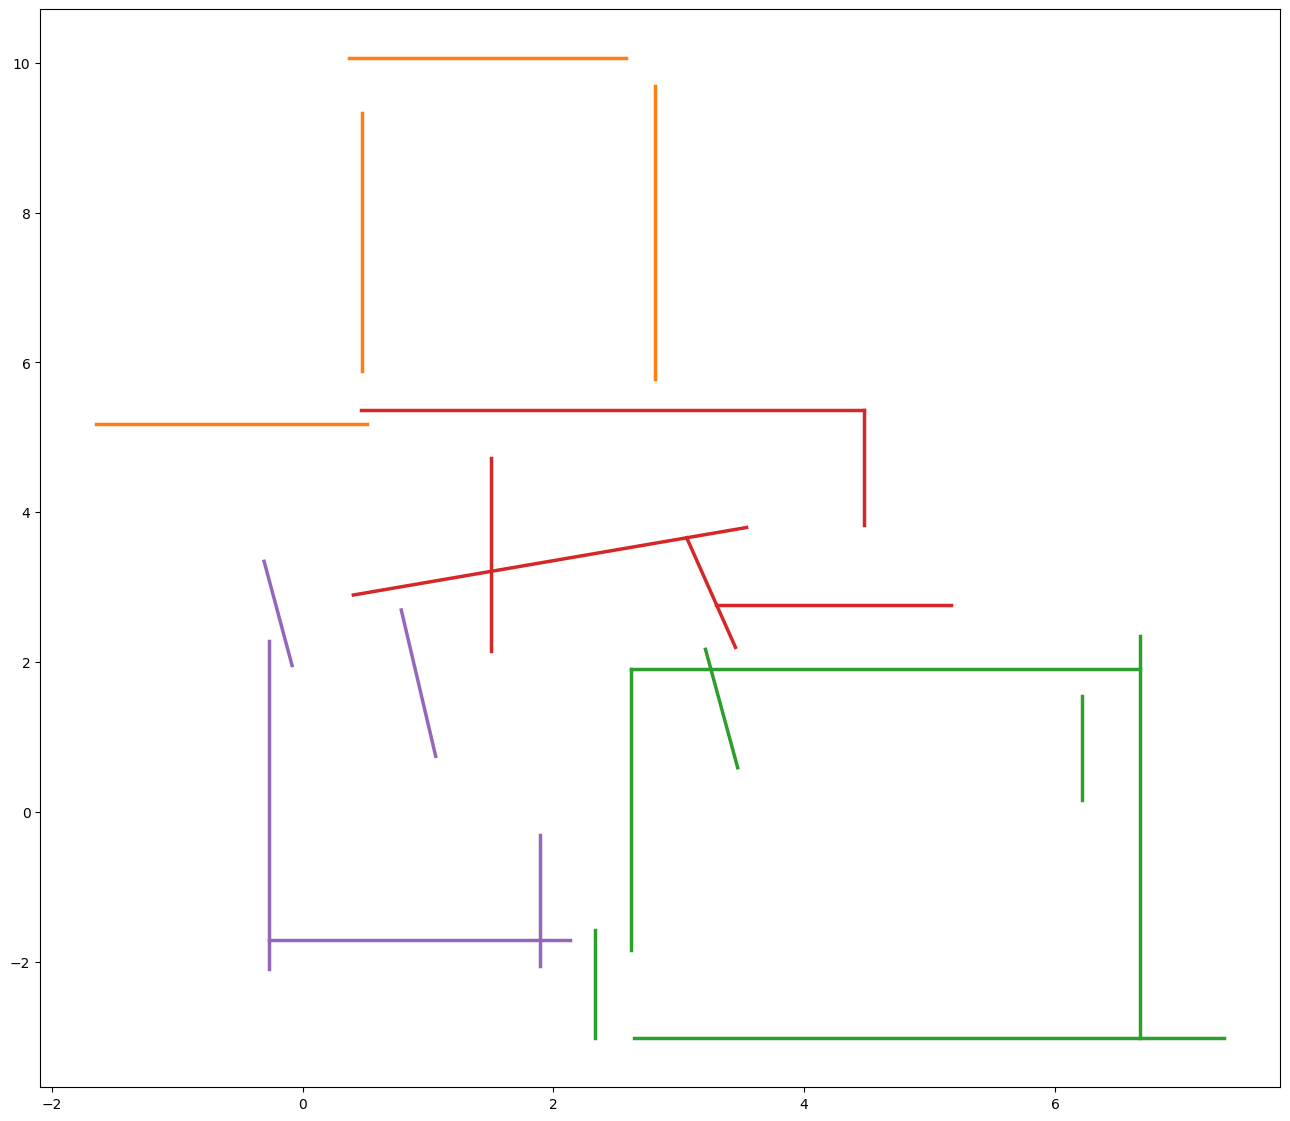

In [307]:
visualize_floorplan_with_corners(wall_lines_final, corners)

In [ ]:
walls = detect_walls_per_room(
    vertical_points,
    point_room_ids,
    num_rooms,
    distance_threshold=0.03,
    min_wall_length=0.5,
    min_inliers=50
)


=== Room 1 ===


IndexError: boolean index did not match indexed array along axis 0; size of axis is 463278 but size of corresponding boolean axis is 293

In [ ]:
walls = detect_walls_per_room(
    vertical_points,
    point_room_ids,
    num_rooms,
    distance_threshold=0.03,
    min_wall_length=0.5,
    min_inliers=50
)


=== Room 1 ===


IndexError: boolean index did not match indexed array along axis 0; size of axis is 463278 but size of corresponding boolean axis is 293

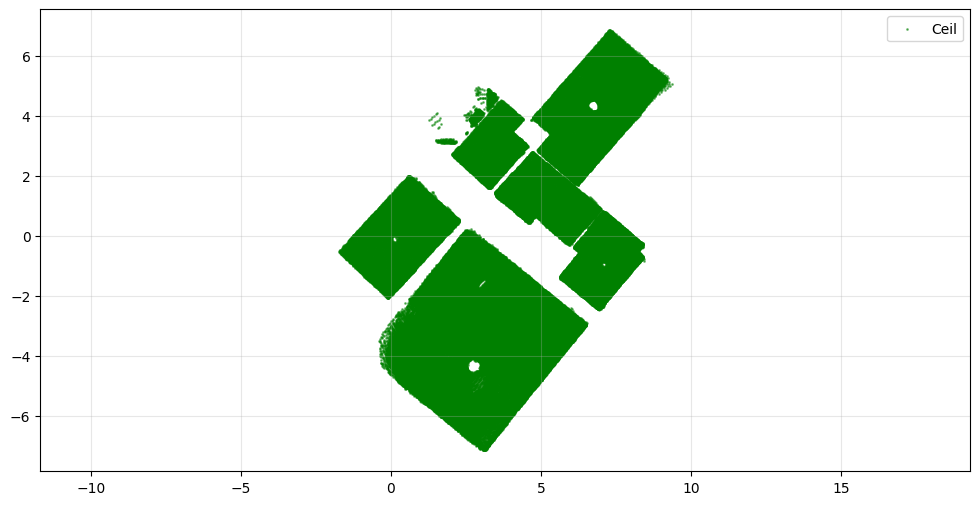

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Ceil', alpha=0.5)

plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [17]:
clustering = DBSCAN(eps=0.1, min_samples=5, algorithm='kd_tree', n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [18]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 7


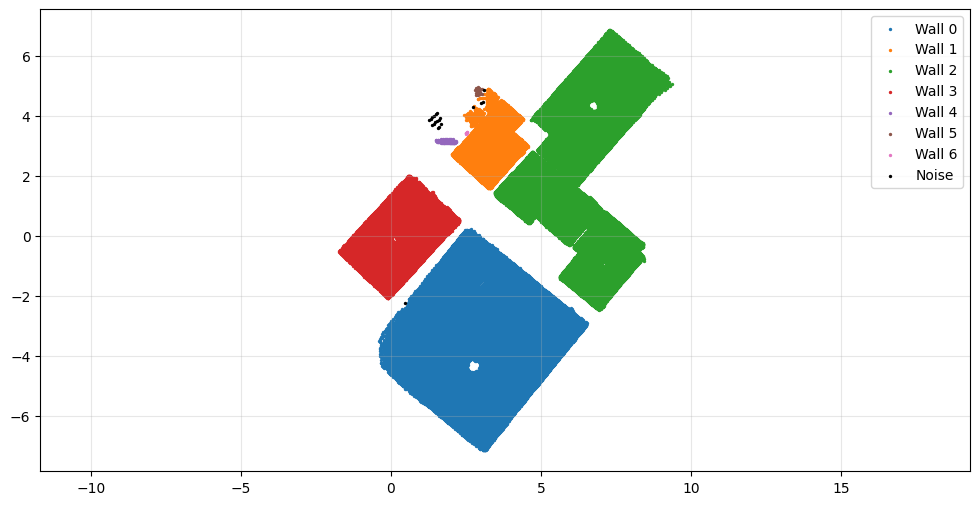

In [19]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 0:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()

plt.grid(True, alpha=0.3)
plt.show()

In [20]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def segment_rooms_hierarchical(ceiling_2d, n_rooms=None, distance_threshold=1.0):
    """
    Use hierarchical clustering - better for rooms with narrow connections
    
    Args:
        ceiling_2d: Nx2 array of ceiling points
        n_rooms: Number of rooms (if known), or None
        distance_threshold: Distance to merge clusters
    """
    
    if n_rooms is not None:
        # If you know how many rooms
        clustering = AgglomerativeClustering(n_clusters=n_rooms)
        labels = clustering.fit_predict(ceiling_2d)
    else:
        # Let algorithm decide based on distance
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            linkage='ward'
        )
        labels = clustering.fit_predict(ceiling_2d)
    
    n_found = len(set(labels))
    print(f"Hierarchical clustering found {n_found} rooms")
    
    return labels

In [1]:
def detect_walls_ransac(pcd, gravity=np.array([0,0,1]),
                        dist_thresh=0.02,  # 2 cm tolerance
                        angle_thresh_deg=10,
                        min_inliers=2000,   # depends on your density
                        max_iter=20):

    walls = []
    remaining = pcd
    angle_thresh = np.deg2rad(angle_thresh_deg)

    for i in range(max_iter):
        if len(remaining.points) < min_inliers:
            break

        plane_model, inliers = remaining.segment_plane(
            distance_threshold=dist_thresh,
            ransac_n=3,
            num_iterations=1000
        )

        n = np.array(plane_model[:3])
        n /= np.linalg.norm(n)
        d = plane_model[3]

        # angle between normal and gravity
        angle = np.arccos(np.clip(np.abs(np.dot(n, gravity)), -1.0, 1.0))

        if abs(angle - np.pi/2) < angle_thresh:   # near-vertical plane
            walls.append({'normal': n, 'd': d, 'inliers': inliers})

        # remove inliers from cloud regardless
        mask = np.ones(len(remaining.points), dtype=bool)
        mask[inliers] = False
        remaining = remaining.select_by_index(np.where(mask)[0])

        if len(walls) > 20:
            break  # stop if too many planes found (optional)

    return walls

NameError: name 'np' is not defined

In [ ]:
labels

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

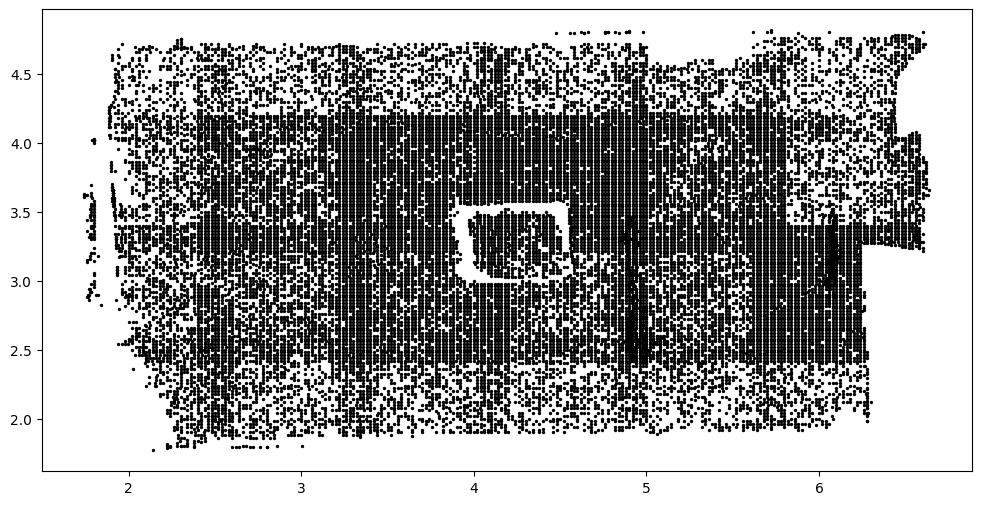

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [ ]:
def rotation_to_align(g, target=np.array([0.,0.,-1.])):
    g = g / np.linalg.norm(g)
    t = target / np.linalg.norm(target)
    c = np.dot(g, t)
    if np.isclose(c, 1.0):
        return np.eye(3)
    if np.isclose(c, -1.0):
        # 180-degree rotation: pick arbitrary orthogonal axis
        # find vector orthogonal to g
        if abs(g[0]) < abs(g[1]):
            axis = np.array([1.,0.,0.])
        else:
            axis = np.array([0.,1.,0.])
        v = np.cross(g, axis)
        v = v / np.linalg.norm(v)
        # Rodrigues with angle = pi
        K = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
        return np.eye(3) + 2*(K @ K)  # since sin(pi)=0, 1-cos(pi)=2 -> simplifies
    v = np.cross(g, t)
    K = np.array([[0, -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    R = np.eye(3) + K + K @ K * (1.0 / (1.0 + c))
    return R

# Example usage:
g = np.array([0.0036468, 0.0030084, -0.9999889])  # example gravity
R = rotation_to_align(g)
points_aligned = (points - points.mean(axis=0)) @ R.T  # center then rotate

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


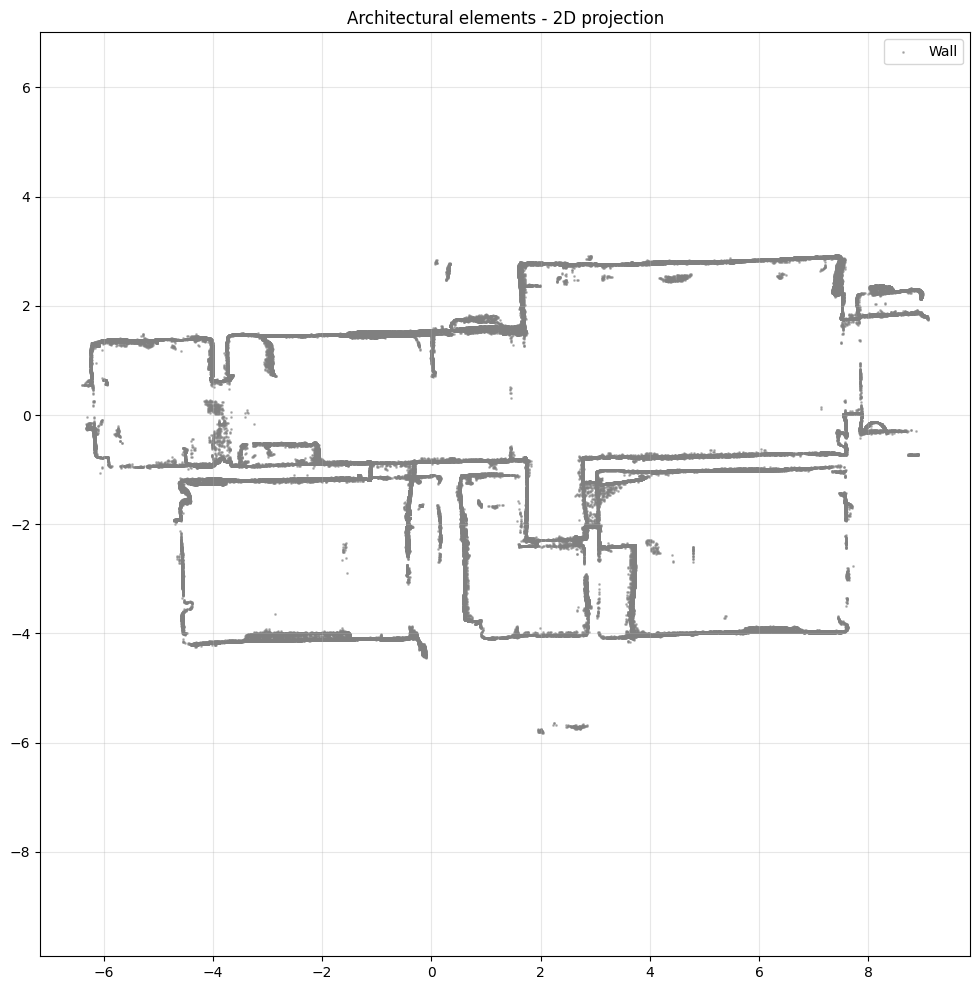

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

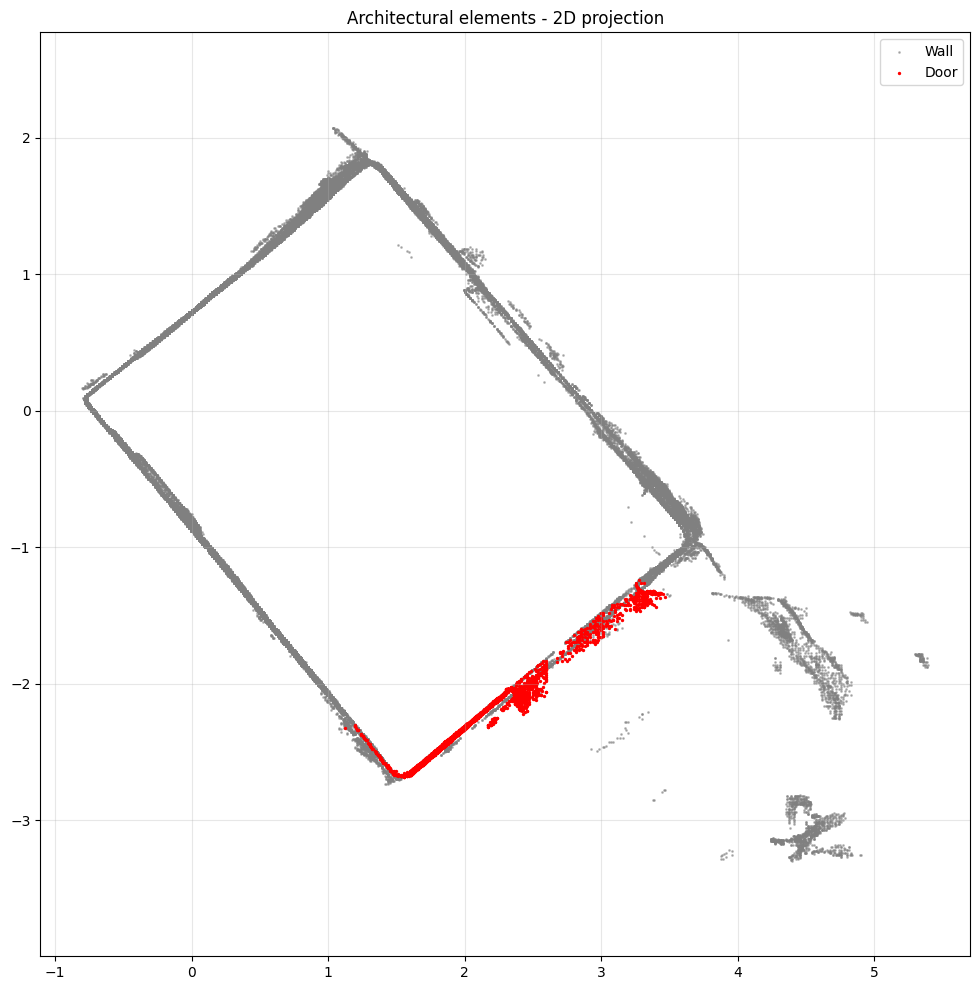

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()